## Noise Augmentation

In [50]:
#Function for creating a noise vector, must be a 5000x1 array of 0's and 1's. Try to keep noise below xx
import numpy as np
from scipy.ndimage import convolve1d

def add_gaussian_noise_via_convolution_1d(data, sigma_range, E_int, max_chunk_size):
    """
    Add Gaussian noise through convolution using a Gaussian kernel to chunks of data with randomized sizes.

    Parameters:
        data (numpy.ndarray): Input data array (1D, e.g., 5000x1).
        sigma_range (tuple): Range of sigma values for Gaussian smoothing (min, max).
        kernel_size (int): Size of the Gaussian kernel.
        max_chunk_size (int): The maximum chunk size for low sigma values.

    Returns:
        numpy.ndarray: Data with added Gaussian noise.
    """
    assert len(data.shape) == 1, "Input data must be a 1D array."

    kernel_size = max(1, int(np.round(1.5 / E_int))) 
    modified_data = data.copy()  # Create a copy to modify
    total_length = len(data)  # Total data length
    idx = 0  # Start index for modification

    while idx < total_length:
        # Randomly select a sigma value from the range
        sigma = np.random.uniform(sigma_range[0], sigma_range[1])
        
        # Scale chunk size inversely to sigma
        chunk_size = int(max_chunk_size * (1 - (sigma / sigma_range[1])))
        chunk_size = max(1, chunk_size)  # Ensure at least one element is modified
        
        # Determine end index for this chunk
        end_idx = min(idx + chunk_size, total_length)
        
        # Extract the current chunk
        chunk = modified_data[idx:end_idx]
        
        # Generate a 1D Gaussian kernel
        ax = np.linspace(-(kernel_size - 1) / 2., (kernel_size - 1) / 2., kernel_size)
        kernel = np.exp(-0.5 * (ax / sigma) ** 2)
        kernel /= np.sum(kernel)  # Normalize the kernel
        
        # Convolve the kernel with the 1D chunk
        smoothed_chunk = convolve1d(chunk, kernel, mode='reflect')
        
        # Add random Gaussian noise
        noise = np.random.normal(loc=0, scale=sigma, size=chunk.shape)
        noisy_chunk = smoothed_chunk + noise
        
        # Update the modified data with the noisy chunk
        modified_data[idx:end_idx] = noisy_chunk
        
        # Move to the next chunk
        idx = end_idx

    return modified_data


5


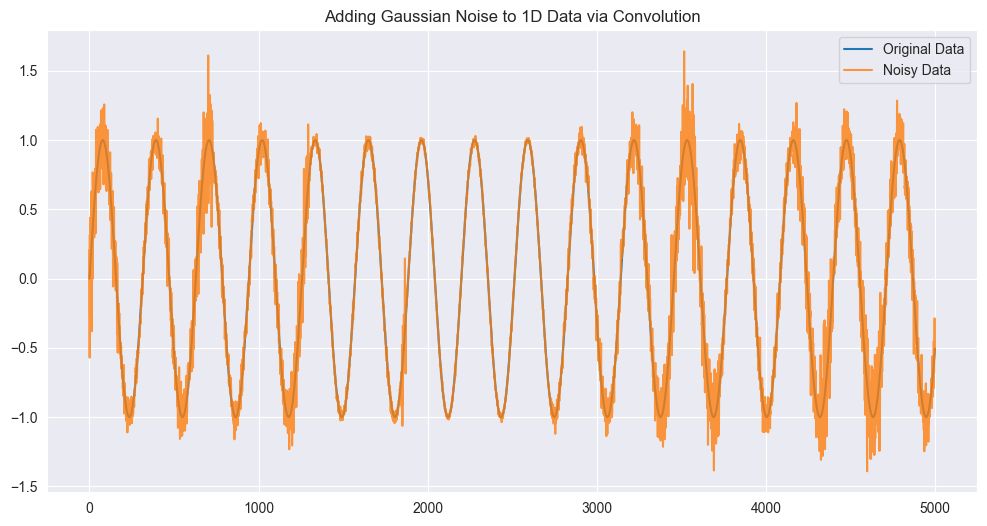

In [38]:
# Example Usage:
# Create a sample 1D array (5000x1 vector)
data = np.linspace(0,100,5000)
data = np.sin(data)
# Apply Gaussian noise via convolution
noisy_data = add_gaussian_noise_via_convolution_1d(data, (0.01,0.3), 0.3, 300)

# Plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(data, label="Original Data")
plt.plot(noisy_data, label="Noisy Data", alpha=0.8)
plt.legend()
plt.title("Adding Gaussian Noise to 1D Data via Convolution")
plt.show()

In [12]:
import numpy as np

def add_randomized_noise(data, noise_range, max_chunk_size):
    """
    Add randomized Gaussian noise to chunks of data.

    Parameters:
        data (numpy.ndarray): Input data array (1D, e.g., 5000x1).
        noise_range (tuple): Range for random noise multiplier (min, max).
        max_chunk_size (int): The maximum chunk size for low noise values.

    Returns:
        numpy.ndarray: Data with added noise.
    """
    assert len(data.shape) == 1, "Input data must be a 1D array."
    
    modified_data = data.copy()  # Create a copy to modify
    total_length = len(data)  # Total data length
    idx = 0  # Start index for modification

    while idx < total_length:
        # Randomly select a noise multiplier from the range
        noise_multiplier = np.random.uniform(noise_range[0], noise_range[1])
        
        # Scale chunk size inversely to noise magnitude
        chunk_size = int(max_chunk_size * (1 - noise_multiplier))
        chunk_size = max(1, chunk_size)  # Ensure at least one element is modified
        
        # Determine end index for this chunk
        end_idx = min(idx + chunk_size, total_length)
        
        # Apply noise to the current chunk
        modified_data[idx:end_idx] *= (1 + noise_multiplier)
        
        # Move to the next chunk
        idx = end_idx

    return modified_data

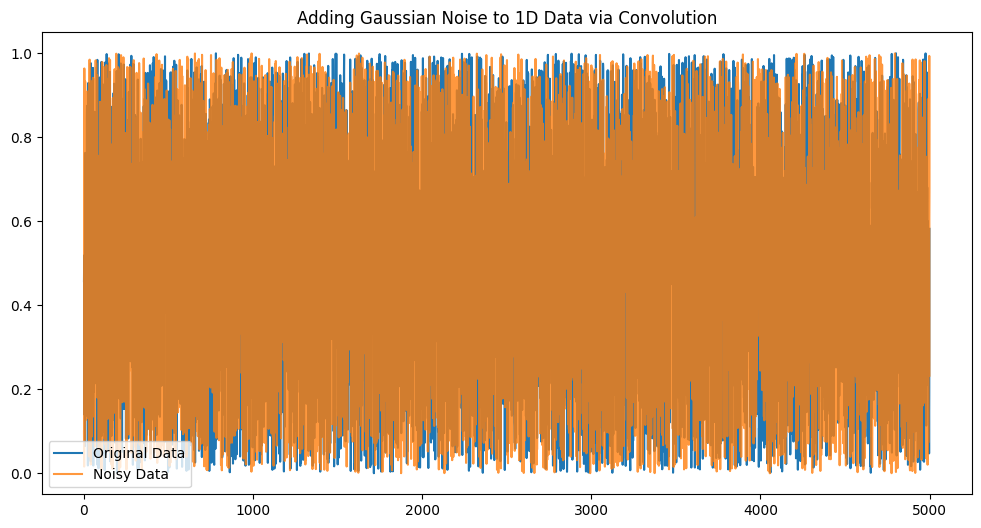

In [13]:
# Example Usage:
# Create a sample 1D array (5000x1 vector)
data = np.random.random(5000)
noise_range = (0, 0.5)  # Noise range
modified_data = add_randomized_noise(data, noise_range,100)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(data, label="Original Data")
plt.plot(noisy_data, label="Noisy Data", alpha=0.8)
plt.legend()
plt.title("Adding Gaussian Noise to 1D Data via Convolution")
plt.show()

## Instrumental Broadening

## Shift Augmentation

In [57]:
import numpy as np
# given a set of vectors consisting of values, move all the values to the right or left by a certain amount

def shift_spectra(energy_interval, energy_shift, intensity):

	random_shift = np.random.uniform(-energy_shift, energy_shift, size = (intensity.shape[0], 1))
	shifted_energy = random_shift/energy_interval
	shifted_energy = shifted_energy.astype(int)
	intensity = intensity.copy()
	for idx, inten in enumerate(intensity):
		intensity[idx] = np.roll(inten, shifted_energy[idx])

	return intensity


## Total Augmentation pipeline

In [31]:
import numpy as np
#load dataset
path = '../dataset'
x_train = np.load(f'{path}/x_train.npy')
y_train = np.load(f'{path}/y_train.npy')

In [64]:
# Add noise to the training data

def add_noise_total(x_train, energy_interval):

    augment_strength = [0.01, 0.05, 0.1]
    x_train_augment = x_train.copy()
    x_train_augmented = np.zeros((len(augment_strength), x_train.shape[0], x_train.shape[1]))
    for idx1, x_train_sample in enumerate(x_train_augment):
        for idx, i in enumerate(augment_strength):
            sigma_min_max = (i*np.max(x_train_sample), (i+0.05)*np.max(x_train_sample))
            x_train_augmented[idx][idx1] = add_gaussian_noise_via_convolution_1d(x_train_sample, sigma_min_max, energy_interval, 300)

    return x_train_augmented

In [65]:
def add_shift_total(x_train, energy_interval):
    energy_shift = 4
    x_train_augment = x_train.copy()
    x_train_augmented = np.zeros((1, x_train.shape[0], x_train.shape[1]))
    for idx1, x_train_sample in enumerate(x_train_augment):
        x_train_augmented[0][idx1] = shift_spectra(energy_interval, energy_shift, x_train_sample)

    return x_train_augmented

In [66]:
def add_augment_total(x_train, energy_interval):
    noise_augment = add_noise_total(x_train, energy_interval)
    shift_augment = add_shift_total(x_train, energy_interval)

    total_augment = np.concatenate((noise_augment, shift_augment), axis = 0)
    return total_augment

In [67]:
x_train_augmented = add_augment_total(x_train, 0.1)